In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice
from SNARS import Snars
from time import sleep
import re
import json

## P8.1
Prepare a code which draw for given network plot of the relation $C(k)$ [20%]

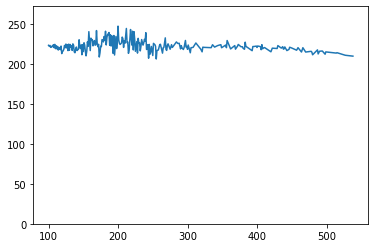

In [2]:
G = nx.generators.barabasi_albert_graph(1000, 100)
def plot_clustering_coeficient(G):
    def avg_degree(G: nx.Graph, k: int) -> float:
        dg =  dict(G.degree)
        k_nodes = [n for n, v in dg.items() if v==k] 
        averages = list(sum(dg[i] for i in G.neighbors(node))/k
                for node in k_nodes) ## list of Average degree of the nearest node for each node of degree k 
        return np.mean(averages)
    X = np.unique(list(dict(G.degree).values()))
    Y = list(map(lambda x: avg_degree(G, x), X))
    plt.plot(X, Y)
    plt.ylim(0, max(Y)*1.1)
plot_clustering_coeficient(G)

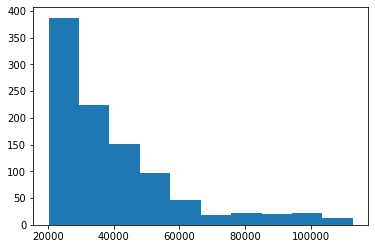

In [3]:
def plot_clustering_coeficient_hist(G):
    def avg_degree(G: nx.Graph, i: int) -> float:
        dg =  dict(G.degree)
        return sum(dg[n] for n in G.neighbors(i))## list of Average degree of the nearest node for each node of degree k 
    Y = list(map(lambda i: avg_degree(G, i), G.nodes))
    plt.hist(Y)
plot_clustering_coeficient_hist(G)

## P8.2
Find examples of hierarchical and non-hierarchical networks inavailable repositories, check by drawing graphs from the taskP8.1. [10%]

## P8.3
Load (perhaps a sub-) set of stops from the data provided byZTM Warszawa on the websitewww.ztm.waw.pl/pliki-do-pobrania/dane-rozkladowe/. Draw graphsbased on this set of vertices associated with the various typesof mass transport. [50%]

In [4]:
routes = json.load(open("routes_week.json", 'r'))
points = json.load(open("points.json", 'r'))
points = {k: (v['lon'], v['lat']) for k, v in points.items()}
edge_list=[]
for k,v in routes.items():
    for end in v.keys():
        edge_list+=[(k, end)]
G = nx.from_edgelist(edge_list)

In [5]:
# fig, ax = plt.subplots(figsize=(15,10))
# nx.draw_spring(G, node_size =1, ax=ax )

## P8.4
Calculate the basic characteristics of each layer, and the wholenetwork. [20%]

## P8.5

Translate GPS coordinates to configuration of the vertices anddraw graph in proper, geographic, configuration. [30%]

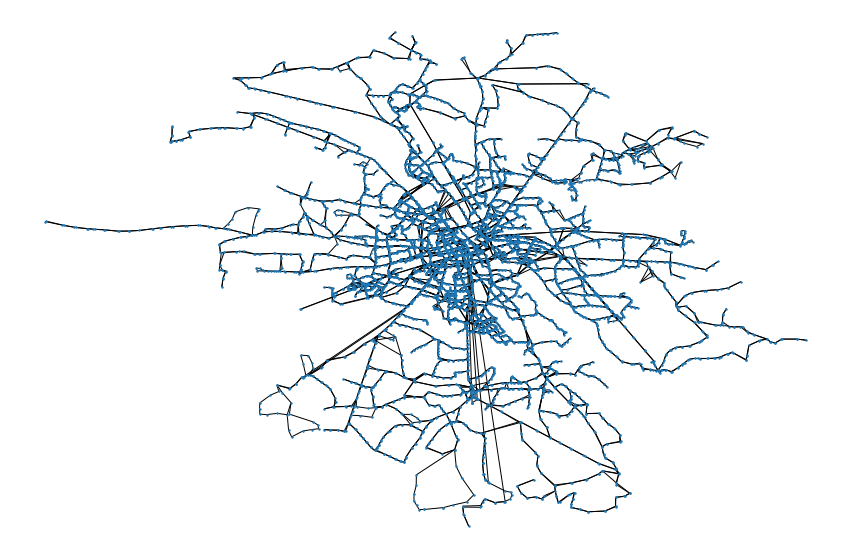

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(G, pos=points, node_size =2, ax=ax)

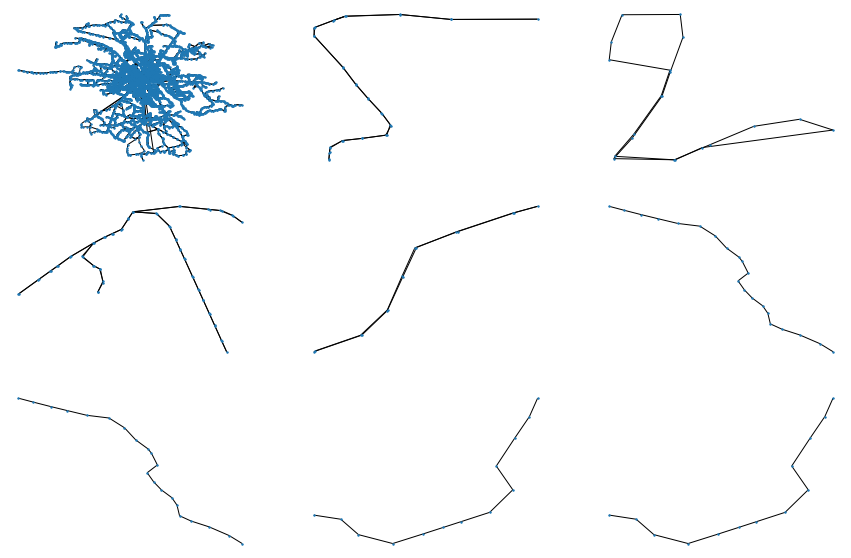

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(15,10))
for i, v in enumerate(nx.connected_components(G)):
    g = nx.subgraph(G, v)
    nx.draw(g, pos=points, node_size =2, ax=ax[i//3, i%3])

## P8.9
Working in groups, let’s ask ourselves a simple researchquestion about the ZTM network and try to answer it! [50%]

In [8]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


In [11]:
points_time = json.load(open("points.json", 'r'))
start = "100101"
def get_route_limited_time(node, time_left):
    result = set()
    if time_left <=0: return result
    for point, time in points_time[node]['routes'].items():
        if time<= time_left:
            result.add(point)
        if time<time_left and time>0:
            result = result.union(get_route_limited_time(point, time_left-time))
    lat, lon = points_time[node]['lat'], points_time[node]['lon']
    for point, spec in points_time.items():
        if haversine(lon, lat, spec['lon'], spec['lat'])<0.2 and (point not in result):
            result.add(point)
            result = result.union(get_route_limited_time(point, time_left-1))
    return result
time_limited_area =dict()
for j in range(1, 10):
    for k in range(10*j):
        time_limited_area[k] =  get_route_limited_time(start, k) 
        print(k, time_limited_area[k])
    json.dump({k: list(v) for k,v in time_limited_area.items()}, open(f"tla{j}.json", 'w'))

0 set()
1 {'200105', '123112', '100101', '200101', '100103', '100188', '100102', '123101', '100108', '100106'}
2 {'200109', '200102', 'M2T009', 'M2K005', '100107', '200104', '200106', '100102', '123101', '200107', '200103', '100188', '200105', '123102', '123112', '100101', '200101', '100103', '123111', '100108', '100106'}
3 {'200109', '200102', '100107', '200104', '200106', '100102', '123101', '200103', '200107', '100188', '200105', '123112', '100101', '200101', '100103', '100108', '100106'}
4 {'200109', '200102', 'M2T009', 'M2K005', '100107', '200104', '200106', '100102', '200107', '123101', '200103', '100188', '100104', '200105', '123102', '123112', '100101', '200101', '100103', '123111', '100108', '100106'}
5 {'200109', '200102', 'M2T009', 'M2K005', '100107', '200104', '200106', '100102', '200107', '123101', '200103', '200201', '290101', '100188', '100104', '200105', '123102', '123112', '100101', '200101', '100103', '290102', '123111', '100108', '100106'}
6 {'200109', '200102', 'M2T

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(nx.subgraph(G, time_limited_area[8]), pos=points, node_size =2, ax=ax)


In [ ]:
%matplotlib notebook
from copy import copy
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10,10))
G = G
def init():
    ax.clear()
    G_plot = nx.Graph()
    G_plot.add_nodes_from(G.nodes)
    G_plot.add_edges_from( nx.subgraph(G, time_limited_area[0]).edges)
    nx.draw(G_plot, pos= points, node_size =0.5, ax=ax)
    return ax
    

def update(frame):
    try:
        ax.clear()
        G_plot = nx.Graph()
        G_plot.add_nodes_from(G.nodes)
        G_plot.add_edges_from( nx.subgraph(G, time_limited_area[int(frame)]).edges)
        nx.draw(G_plot, pos= points, node_size =0.5, ax=ax)
        ax.set_title(f"Iteration nr. {round(frame)}/50")
    except Exception as e:
        print(e)
    return ax

ani = FuncAnimation(fig, update, frames=np.linspace(0, 8), interval=1000, init_func=init)

In [ ]:
times = {0: {'100101'}}
points_time = json.load(open("points.json", 'r'))
def get_near(node):
    result=set()
    lat, lon = points_time[node]['lat'], points_time[node]['lon']
    for k, v in points_time.items():
        if haversine(lon, lat, v['lon'], v['lat'])<=0.300:
            result.add(k)  
    for k, time in points_time[node]["routes"].items():
        if time<=3:
            result.add(k)
    return result 
        
    
for i in range(1, 30):          
    times[i] = times[i-1].union(set([k for node in times[i-1] for k in get_near(node)]))
    print(i, times[i])

In [ ]:
%matplotlib notebook
from copy import copy
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10,10))
G = G
def init():
    ax.clear()
    G_plot = nx.Graph()
    G_plot.add_nodes_from(G.nodes)
    G_plot.add_edges_from( nx.subgraph(G, times[0]).edges)
    nx.draw(G_plot, pos= points, node_size =0.5, ax=ax)
    return ax
    

def update(frame):
    try:
        ax.clear()
        G_plot = nx.Graph()
        G_plot.add_nodes_from(G.nodes)
        G_plot.add_edges_from( nx.subgraph(G, times[int(frame)]).edges)
        nx.draw(G_plot, pos= points, node_size =0.5, ax=ax)
        ax.set_title(f"Iteration nr. {round(frame)}/50")
    except Exception as e:
        print(e)
    return ax

ani = FuncAnimation(fig, update, frames=np.linspace(0, 30), interval=1000, init_func=init)

In [ ]:
G_plot = nx.Graph()
G_plot.add_nodes_from(G.nodes)
G_plot.add_edges_from( nx.subgraph(G, times[29]).edges)
fig, ax = plt.subplots(figsize=(15,10))
nx.draw(G_plot, pos= points, node_size =1, ax=ax)

In [ ]:
czasy = {"100101": 0}
for p in czasy:
    for near in points_time[p]["routes"]:
        